# Imports & Settings

In [1]:
# python = 3.10.14
# anndata = 0.10.7
# squidpy = 1.4.1
# numpy = 1.23.4
# scipy = 1.12.0
# seaborn = 0.13.2

import anndata as ad
import colorcet as cc
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import squidpy as sq

filepath = "spat_reseg5.h5ad"

In [2]:
ct_of_interest = [
    "PT_Injury_m1",
    "PT_Injury_m2",
    "PT_Injury_m3",
    "PT_Injury_m4",
    "PT_prolif",
    "TAL_Injury_m1",
    "TAL_Injury_m2",
    "TAL_Injury_m3",
    "TAL_Prolif",
]

immune = [
    "Cd8+ T cells",
    "Cd4+ T cells",
    "Myeloid",
]

# naming convention for TeX labeling
ct_rename = {
    "Cd8+ T cells": "CD8^{+}\ T\ cells",
    "Cd4+ T cells": "CD4^{+}\ T\ cells",
    "Myeloid": "Macrophages",
}

# Prepare data

In [3]:
adata = ad.read_h5ad(filepath)

In [4]:
# merge celltypes

other = "other"  # catch-all category for celltypes not of interest

celltype_mapping = {
    ct: (ct if ct in immune + ct_of_interest else other)
    for ct in adata.obs["celltype_level_2"].cat.categories
}
celltype_mapping["Cd8+ T cells_2_prolif"] = "Cd8+ T cells"

adata.obs = adata.obs.assign(
    celltype=lambda df: df["celltype_level_2"]
    .map(celltype_mapping)
    .fillna(other)
    .astype("category")
)

# define immune sub celltypes of interest
immune_sub = (
    adata.obs.loc[lambda df: df["celltype"].isin(immune), "celltype_level_3"]
    .unique()
    .tolist()
)

celltype_sub_mapping = {
    ct: (ct if ct in immune_sub + ct_of_interest else other)
    for ct in adata.obs["celltype_level_3"].cat.categories
}

adata.obs = adata.obs.assign(
    celltype_sub=lambda df: df["celltype_level_3"]
    .map(celltype_sub_mapping)
    .fillna(other)
    .astype("category")
)

adata.obs = adata.obs[["sample", "broad.group", "celltype", "celltype_sub"]]

In [5]:
adata.obs["celltype"].value_counts()

celltype
other            770679
Myeloid          440160
Cd8+ T cells     147956
PT_Injury_m2      77807
PT_Injury_m3      43914
Cd4+ T cells      39854
TAL_Injury_m1     21846
PT_Injury_m4      19015
PT_Injury_m1      13976
TAL_Injury_m3      2930
TAL_Injury_m2      1570
PT_prolif           390
TAL_Prolif           50
Name: count, dtype: int64

In [6]:
case_control = (
    adata.obs.groupby("broad.group", observed=True)["sample"].agg(set).to_dict()
)
case_control

{'control': {'bc.bc', 'bl6.bl6'},
 'rejection': {'bc.bl6.1', 'bc.bl6.3', 'bl6.bc.1', 'bl6.bc.2', 'bl6.bc.3'}}

In [7]:
celltypes = list(adata.obs["celltype"].cat.categories)
celltypes_sub = list(adata.obs["celltype_sub"].cat.categories)

ct_definitions = {
    "celltype": celltypes,
    "celltype_sub": celltypes_sub,
}

# Compute co-occurence

In [ ]:
# split by sample
adatas = {
    key: adata[idxs, :].copy()
    for key, idxs in adata.obs.groupby("sample", observed=True).indices.items()
}

del adata

In [ ]:
interval = np.arange(25, 251, step=25)

for name, ct in ct_definitions.items():
    print(f"Processing {name}")
    with h5py.File(f"co_occurence_long_{name}.hdf5", "w-") as f:
        f.create_dataset("celltypes", data=ct)
        f.create_dataset("interval", data=interval)
        samples = f.create_group("samples")

        for sample, adata in adatas.items():
            print(f"Processing {sample}")
            sq.gr.co_occurrence(
                adata,
                cluster_key=name,
                interval=interval,
                n_splits=1,  # requires a lot (!) of memory but otherwise doesn't work; https://github.com/scverse/squidpy/issues/755
                show_progress_bar=False,
            )

            samples.create_dataset(
                sample, data=adata.uns[f"{name}_co_occurrence"]["occ"]
            )

In [ ]:
interval = np.arange(5, 51, step=5)

for name, ct in ct_definitions.items():
    print(f"Processing {name}")
    with h5py.File(f"co_occurence_short_{name}.hdf5", "w-") as f:
        f.create_dataset("celltypes", data=ct)
        f.create_dataset("interval", data=interval)
        samples = f.create_group("samples")

        for sample, adata in adatas.items():
            print(f"Processing {sample}")
            sq.gr.co_occurrence(
                adata,
                cluster_key=name,
                interval=interval,
                n_splits=1,  # requires a lot (!) of memory but otherwise doesn't work
                show_progress_bar=False,
            )

            samples.create_dataset(
                sample, data=adata.uns[f"{name}_co_occurrence"]["occ"]
            )

# Plotting

In [8]:
import matplotlib as mpl

mpl.rcParams["font.size"] = 8
mpl.rcParams["xtick.labelsize"] = 6
mpl.rcParams["ytick.labelsize"] = 6
mpl.rcParams["axes.labelsize"] = 8
mpl.rcParams["axes.titlesize"] = 10

CM = 1 / 2.54

In [9]:
# remove PT/TAL_Prolif because they have very low cell numbers and the estimates are extremely noisy
ct_of_interest = [x for x in ct_of_interest if "rolif" not in x]

In [10]:
from scipy.stats import false_discovery_control, shapiro, ttest_1samp

In [11]:
def load_cooccurence(filepath, cond, exp, keep=case_control["rejection"]):
    data = {}

    with h5py.File(filepath, "r") as f:
        interval = f["interval"].astype(int)
        celltypes = list(f["celltypes"][:].astype(str))
        ct_index = pd.Index(celltypes, name="celltype2")

        for name, occ in f["samples"].items():
            if name not in keep:
                continue

            sample_data = {
                ct: pd.DataFrame(
                    occ[celltypes.index(ct), :, :], index=ct_index, columns=interval[1:]
                ).loc[exp, :]
                for ct in cond
            }
            data[name] = pd.concat(sample_data, names=["celltype"])

    data = pd.concat(data, names=["sample"]).melt(
        var_name="distance", value_name="ratio", ignore_index=False
    )
    data = {
        ct: df.reset_index().drop(columns=["celltype2"])
        for ct, df in data.groupby("celltype2")
    }
    return data

## Celltypes

In [12]:
n_ct = len(ct_of_interest)
n_immune = len(immune)

In [13]:
data = load_cooccurence("co_occurence_short_celltype.hdf5", ct_of_interest, immune)

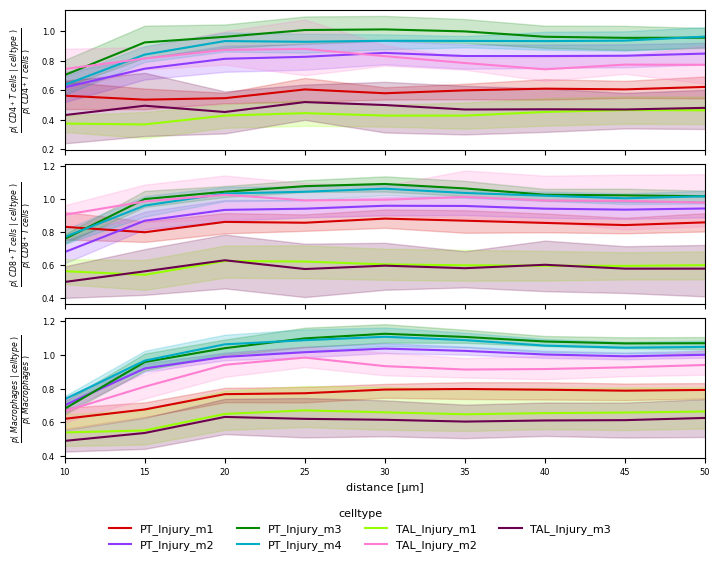

In [14]:
fig, axs = plt.subplots(
    n_immune, sharex=True, figsize=(18 * CM, 14 * CM), layout="constrained"
)

for i, ct in enumerate(data.keys()):
    legend = "brief" if i == 0 else False
    sns.lineplot(
        data[ct],
        x="distance",
        y="ratio",
        hue="celltype",
        palette=cc.glasbey[:n_ct],
        legend=legend,
        ax=axs[i],
    )

    ct = ct_rename[ct]
    axs[i].set_ylabel(r"$\frac{p(\ " + ct + r"\ |\ celltype\ )}{p(\ " + ct + r"\ )}$")
    axs[i].set_xlabel("distance [µm]")

fig.legend(
    *axs[0].get_legend_handles_labels(),
    loc="outside lower center",
    title="celltype",
    frameon=False,
    ncols=4
)
axs[0].get_legend().remove()

_ = axs[0].set(xlim=(10, 50))

fig.savefig("enrichment.png", dpi=600)
fig.savefig("enrichment.svg")

In [15]:
distance = 25  # um

dist_25 = {ct: df.loc[lambda df: df["distance"] == distance] for ct, df in data.items()}

pd.concat(dist_25, names=["leukocyte"]).reset_index(level=0).pivot(
    index=["sample", "celltype"], columns="leukocyte", values="ratio"
).to_csv("dist25_probability_ratios.tsv", sep="\t")

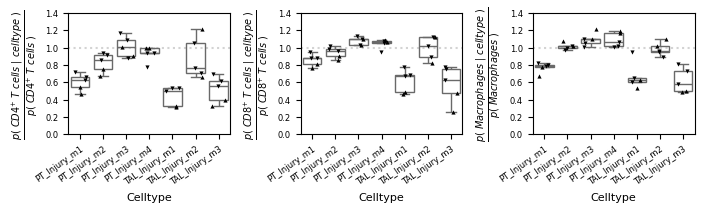

In [16]:
fig, axs = plt.subplots(
    ncols=len(dist_25), sharex=True, sharey=True, figsize=(18 * CM, 5.5 * CM)
)
fig.subplots_adjust(wspace=0.6)

marker = {"bl6.bc": "v", "bc.bl6": "^"}

flier = dict(marker=".", markerfacecolor="black", markersize=2)
jitter = dict(c="black", linewidth=0, jitter=0.3, s=3)

for ct, ax in zip(dist_25, axs):
    kwargs = dict(x="celltype", y="ratio", ax=ax)

    data = dist_25[ct].assign(group=lambda df: df["sample"].str.rsplit(".", n=1).str[0])
    ax.axhline(y=1, linestyle=":", color="lightgrey")
    sns.boxplot(
        data=data,
        linecolor="dimgrey",
        showfliers=False,
        boxprops=dict(facecolor="none"),
        **kwargs
    )
    ax.set_xlabel("Celltype")
    ax.set_xticks(
        ax.get_xticks(),
        ax.get_xticklabels(),
        rotation=35,
        ha="right",
        rotation_mode="anchor",
    )

    for g, df in data.groupby("group"):
        sns.stripplot(data=df, marker=marker[g], **kwargs, **jitter)

    ct = ct_rename[ct]
    ax.set_ylabel(
        r"$\frac{p(\ " + ct + r"\ |\ celltype\ )}{p(\ " + ct + r"\ )}$", fontsize=10
    )
    axs[0].set(ylim=(0, 1.4))
    for ax in axs:
        ax.tick_params(labelleft=True)

fig.tight_layout()

fig.savefig("enrichment_dist25.png", dpi=600)
fig.savefig("enrichment_dist25.svg")

In [17]:
pvals = (
    pd.concat(dist_25, names=["immune_ct"])
    .reset_index()
    .groupby(["immune_ct", "celltype"])
    .agg(
        p_shapiro_wilk=("ratio", lambda s: shapiro(s).pvalue),
        p_ttest_1s=("ratio", lambda s: ttest_1samp(s, 1).pvalue),
    )
    .assign(
        p_adjust_BH=lambda df: false_discovery_control(df["p_ttest_1s"], method="bh"),
        p_adjust_BY=lambda df: false_discovery_control(df["p_ttest_1s"], method="by"),
    )
)
pvals.to_csv("dist25_pvalues_celltype.tsv", sep="\t", float_format="%.3g")

pvals

p_shapiro_wilk  p_ttest_1s  p_adjust_BH  \
immune_ct    celltype                                                 
Cd4+ T cells PT_Injury_m1         0.882290    0.000900     0.008004   
             PT_Injury_m2         0.510125    0.026381     0.050364   
             PT_Injury_m3         0.685479    0.879160     0.923118   
             PT_Injury_m4         0.077905    0.144448     0.189588   
             TAL_Injury_m1        0.054120    0.000398     0.008004   
             TAL_Injury_m2        0.277677    0.328240     0.405473   
             TAL_Injury_m3        0.659854    0.002277     0.011954   
Cd8+ T cells PT_Injury_m1         0.896779    0.009785     0.026044   
             PT_Injury_m2         0.840155    0.133293     0.189588   
             PT_Injury_m3         0.466466    0.019748     0.041470   
             PT_Injury_m4         0.024777    0.143603     0.189588   
             TAL_Injury_m1        0.358524    0.003254     0.013667   
             TAL_Injury_m2        0.393526    0.930133     0.930133   
             TAL_Injury_m3        0.482834    0.011162     0.026044   
Myeloid      PT_Injury_m1         0.108672    0.001143     0.008004   
             PT_Injury_m2         0.685441    0.428770     0.500231   
             PT_Injury_m3         0.632787    0.046639     0.081619   
             PT_Injury_m4         0.253359    0.084044     0.135763   
             TAL_Injury_m1        0.087028    0.010592     0.026044   
             TAL_Injury_m2        0.919618    0.659713     0.729156   
             TAL_Injury_m3        0.371949    0.004284     0.014995   

                            p_adjust_BY  
immune_ct    celltype                    
Cd4+ T cells PT_Injury_m1      0.029179  
             PT_Injury_m2      0.183596  
             PT_Injury_m3      1.000000  
             PT_Injury_m4      0.691117  
             TAL_Injury_m1     0.029179  
             TAL_Injury_m2     1.000000  
             TAL_Injury_m3     0.043576  
Cd8+ T cells PT_Injury_m1      0.094938  
             PT_Injury_m2      0.691117  
             PT_Injury_m3      0.151175  
             PT_Injury_m4      0.691117  
             TAL_Injury_m1     0.049821  
             TAL_Injury_m2     1.000000  
             TAL_Injury_m3     0.094938  
Myeloid      PT_Injury_m1      0.029179  
             PT_Injury_m2      1.000000  
             PT_Injury_m3      0.297530  
             PT_Injury_m4      0.494905  
             TAL_Injury_m1     0.094938  
             TAL_Injury_m2     1.000000  
             TAL_Injury_m3     0.054663

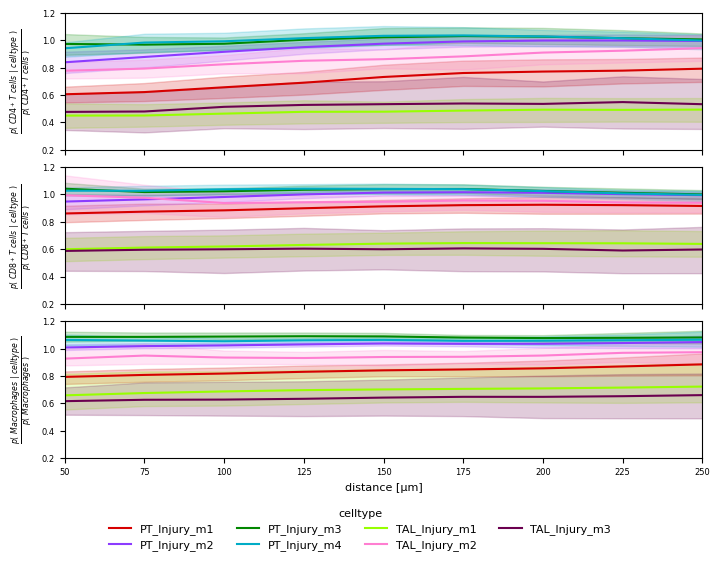

In [18]:
data = load_cooccurence("co_occurence_long_celltype.hdf5", ct_of_interest, immune)

fig, axs = plt.subplots(
    n_immune, sharex=True, sharey=True, figsize=(18 * CM, 14 * CM), layout="constrained"
)

for i, ct in enumerate(data.keys()):
    legend = "brief" if i == 0 else False
    sns.lineplot(
        data[ct],
        x="distance",
        y="ratio",
        hue="celltype",
        palette=cc.glasbey[:n_ct],
        legend=legend,
        ax=axs[i],
    )

    ct = ct_rename[ct]
    axs[i].set_ylabel(r"$\frac{p(\ " + ct + r"\ |\ celltype\ )}{p(\ " + ct + r"\ )}$")
    axs[i].set_xlabel("distance [µm]")

fig.legend(
    *axs[0].get_legend_handles_labels(),
    loc="outside lower center",
    title="celltype",
    frameon=False,
    ncols=4
)
axs[0].get_legend().remove()

_ = axs[0].set(ylim=(0.2, 1.2), xlim=(50, 250))

fig.savefig("enrichment_dist_long.png", dpi=600)
fig.savefig("enrichment_dist_long.svg")

## Sub-Celltypes

In [19]:
n_immune = len(immune_sub)

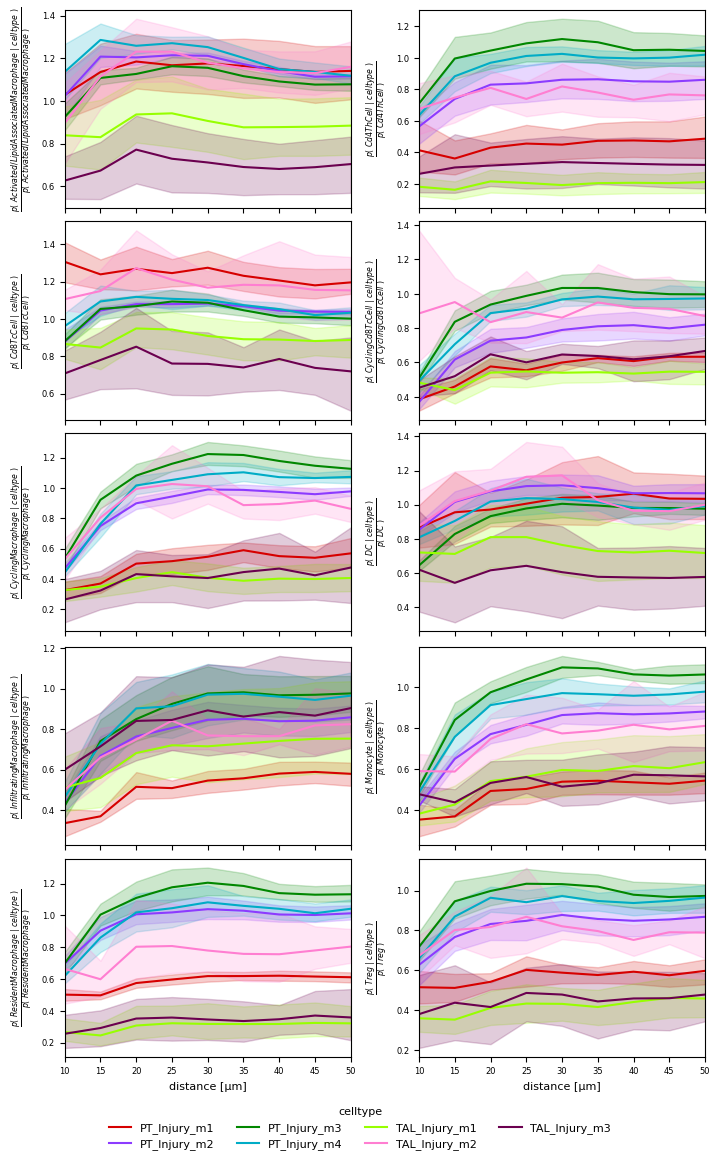

In [20]:
data = load_cooccurence(
    "co_occurence_short_celltype_sub.hdf5", ct_of_interest, immune_sub
)

n_rows = n_immune // 2

fig, axs = plt.subplots(
    n_rows, 2, sharex=True, figsize=(18 * CM, 2.3 * n_rows), layout="constrained"
)

for i, (ct, ax) in enumerate(zip(data.keys(), axs.ravel())):
    legend = "brief" if i == 0 else False
    sns.lineplot(
        data[ct],
        x="distance",
        y="ratio",
        hue="celltype",
        palette=cc.glasbey[:n_ct],
        legend=legend,
        ax=ax,
    )

    ax.set_ylabel(r"$\frac{p(\ " + ct + r"\ |\ celltype\ )}{p(\ " + ct + r"\ )}$")
    ax.set_xlabel("distance [µm]")
    ax.yaxis.get_label().set_visible(True)

fig.legend(
    *axs[0, 0].get_legend_handles_labels(),
    loc="outside lower center",
    title="celltype",
    frameon=False,
    ncols=4
)
axs[0, 0].get_legend().remove()

_ = axs[0, 0].set(xlim=(10, 50))

fig.savefig("enrichment_subtypes.png", dpi=600)
fig.savefig("enrichment_subtypes.svg")

In [21]:
distance = 25  # um

dist_25 = {ct: df.loc[lambda df: df["distance"] == distance] for ct, df in data.items()}

pd.concat(dist_25, names=["leukocyte"]).reset_index(level=0).pivot(
    index=["sample", "celltype"], columns="leukocyte", values="ratio"
).to_csv("dist25_probability_ratios_subtypes.tsv", sep="\t")

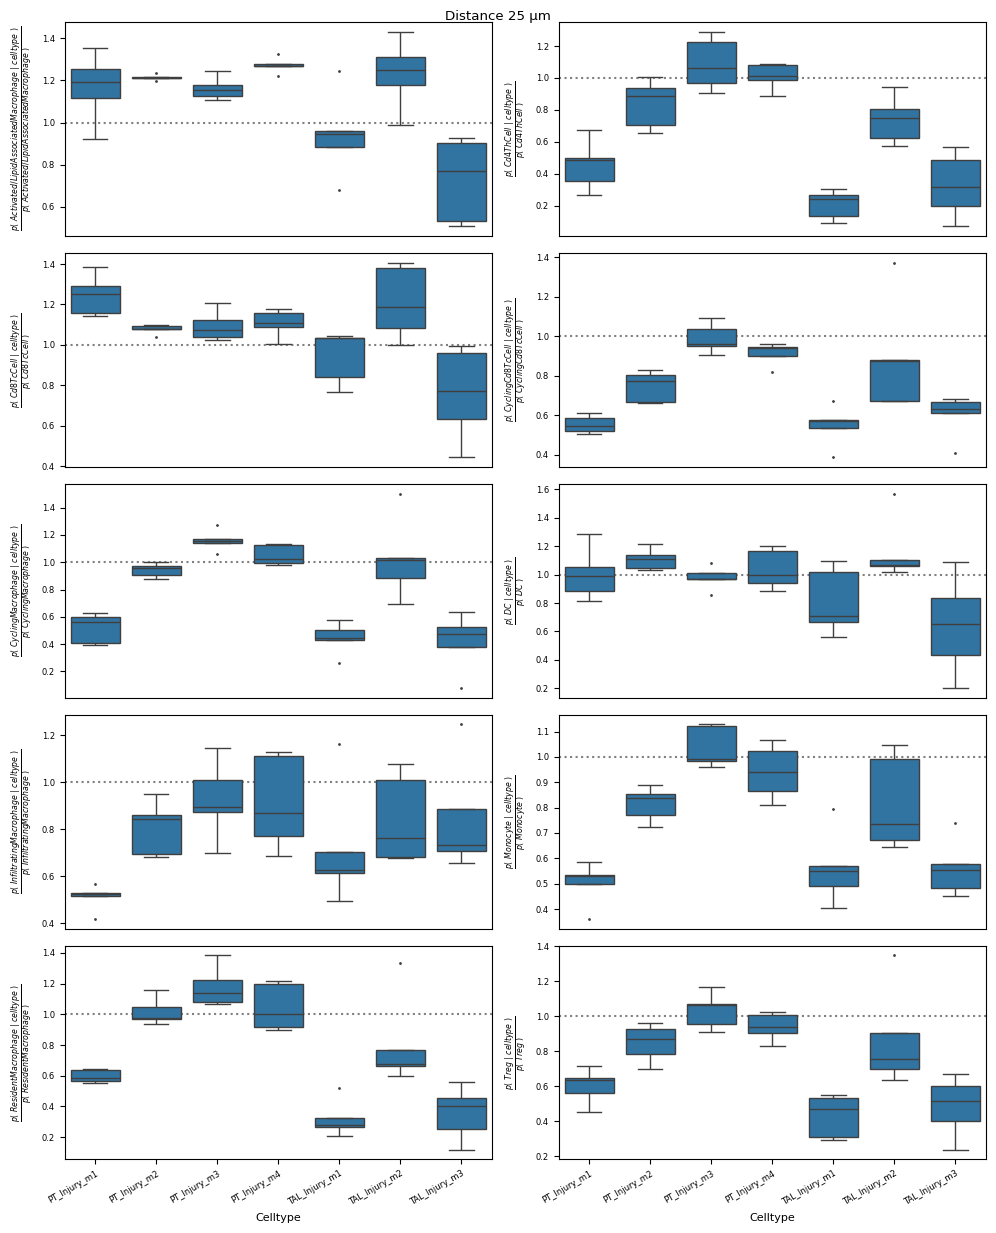

In [22]:
fig, axs = plt.subplots(
    len(dist_25) // 2, 2, sharex=True, figsize=(10, 2.5 * n_immune / 2)
)

flier = dict(marker=".", markerfacecolor="black", markersize=2)

for i, (ct, ax) in enumerate(zip(dist_25, axs.ravel())):
    ax.axhline(y=1, linestyle=":", color="grey")
    sns.boxplot(data=dist_25[ct], x="celltype", y="ratio", flierprops=flier, ax=ax)
    ax.yaxis.get_label().set_visible(True)
    ax.set_ylabel(r"$\frac{p(\ " + ct + r"\ |\ celltype\ )}{p(\ " + ct + r"\ )}$")
    ax.set_xlabel("Celltype")
    if i < n_immune - 2:
        ax.tick_params(axis="x", bottom=False)
    else:
        ax.set_xticks(
            ax.get_xticks(),
            ax.get_xticklabels(),
            rotation=30,
            ha="right",
            rotation_mode="anchor",
        )

fig.suptitle(f"Distance {distance} µm")
fig.tight_layout()

In [23]:
pvals = (
    pd.concat(dist_25, names=["immune_ct"])
    .reset_index()
    .groupby(["immune_ct", "celltype"])
    .agg(
        p_shapiro_wilk=("ratio", lambda s: shapiro(s).pvalue),
        p_ttest_1s=("ratio", lambda s: ttest_1samp(s, 1).pvalue),
    )
    .assign(
        p_adjust_BH=lambda df: false_discovery_control(df["p_ttest_1s"], method="bh"),
        p_adjust_BY=lambda df: false_discovery_control(df["p_ttest_1s"], method="by"),
    )
)
pvals.to_csv("dist25_pvalues_celltype_sub.tsv", sep="\t", float_format="%.3g")

pvals

p_shapiro_wilk  \
immune_ct                             celltype                        
Activated/Lipid Associated Macrophage PT_Injury_m1         0.880590   
                                      PT_Injury_m2         0.834659   
                                      PT_Injury_m3         0.762376   
                                      PT_Injury_m4         0.614057   
                                      TAL_Injury_m1        0.713405   
...                                                             ...   
Treg                                  PT_Injury_m3         0.716534   
                                      PT_Injury_m4         0.705028   
                                      TAL_Injury_m1        0.184844   
                                      TAL_Injury_m2        0.161335   
                                      TAL_Injury_m3        0.823453   

                                                     p_ttest_1s  p_adjust_BH  \
immune_ct                             celltype                                 
Activated/Lipid Associated Macrophage PT_Injury_m1     0.081921     0.130330   
                                      PT_Injury_m2     0.000005     0.000350   
                                      PT_Injury_m3     0.002492     0.007757   
                                      PT_Injury_m4     0.000072     0.000835   
                                      TAL_Injury_m1    0.557952     0.619947   
...                                                         ...          ...   
Treg                                  PT_Injury_m3     0.497940     0.571406   
                                      PT_Injury_m4     0.174280     0.254158   
                                      TAL_Injury_m1    0.000501     0.003508   
                                      TAL_Injury_m2    0.359244     0.455971   
                                      TAL_Injury_m3    0.002549     0.007757   

                                                     p_adjust_BY  
immune_ct                             celltype                    
Activated/Lipid Associated Macrophage PT_Injury_m1      0.629861  
                                      PT_Injury_m2      0.001692  
                                      PT_Injury_m3      0.037487  
                                      PT_Injury_m4      0.004035  
                                      TAL_Injury_m1     1.000000  
...                                                          ...  
Treg                                  PT_Injury_m3      1.000000  
                                      PT_Injury_m4      1.000000  
                                      TAL_Injury_m1     0.016952  
                                      TAL_Injury_m2     1.000000  
                                      TAL_Injury_m3     0.037487  

[70 rows x 4 columns]

In [24]:
# significant tests
alpha = 0.05
for idx, row in pvals.iterrows():
    if row.p_adjust_BH < alpha:
        print(f"{idx[0]} - {idx[1]}:", f"p_adj = {row.p_adjust_BH:.2g}")

Activated/Lipid Associated Macrophage - PT_Injury_m2: p_adj = 0.00035
Activated/Lipid Associated Macrophage - PT_Injury_m3: p_adj = 0.0078
Activated/Lipid Associated Macrophage - PT_Injury_m4: p_adj = 0.00083
Cd4 Th Cell - PT_Injury_m1: p_adj = 0.0058
Cd4 Th Cell - TAL_Injury_m1: p_adj = 0.00052
Cd4 Th Cell - TAL_Injury_m2: p_adj = 0.041
Cd4 Th Cell - TAL_Injury_m3: p_adj = 0.0065
Cd8 Tc Cell - PT_Injury_m1: p_adj = 0.015
Cd8 Tc Cell - PT_Injury_m2: p_adj = 0.0061
Cycling Cd8 Tc Cell - PT_Injury_m1: p_adj = 0.00052
Cycling Cd8 Tc Cell - PT_Injury_m2: p_adj = 0.0065
Cycling Cd8 Tc Cell - TAL_Injury_m1: p_adj = 0.0035
Cycling Cd8 Tc Cell - TAL_Injury_m3: p_adj = 0.0055
Cycling Macrophage - PT_Injury_m1: p_adj = 0.0035
Cycling Macrophage - PT_Injury_m3: p_adj = 0.024
Cycling Macrophage - TAL_Injury_m1: p_adj = 0.0034
Cycling Macrophage - TAL_Injury_m3: p_adj = 0.0099
Infiltrating Macrophage - PT_Injury_m1: p_adj = 0.00052
Infiltrating Macrophage - PT_Injury_m2: p_adj = 0.047
Monocyte - PT

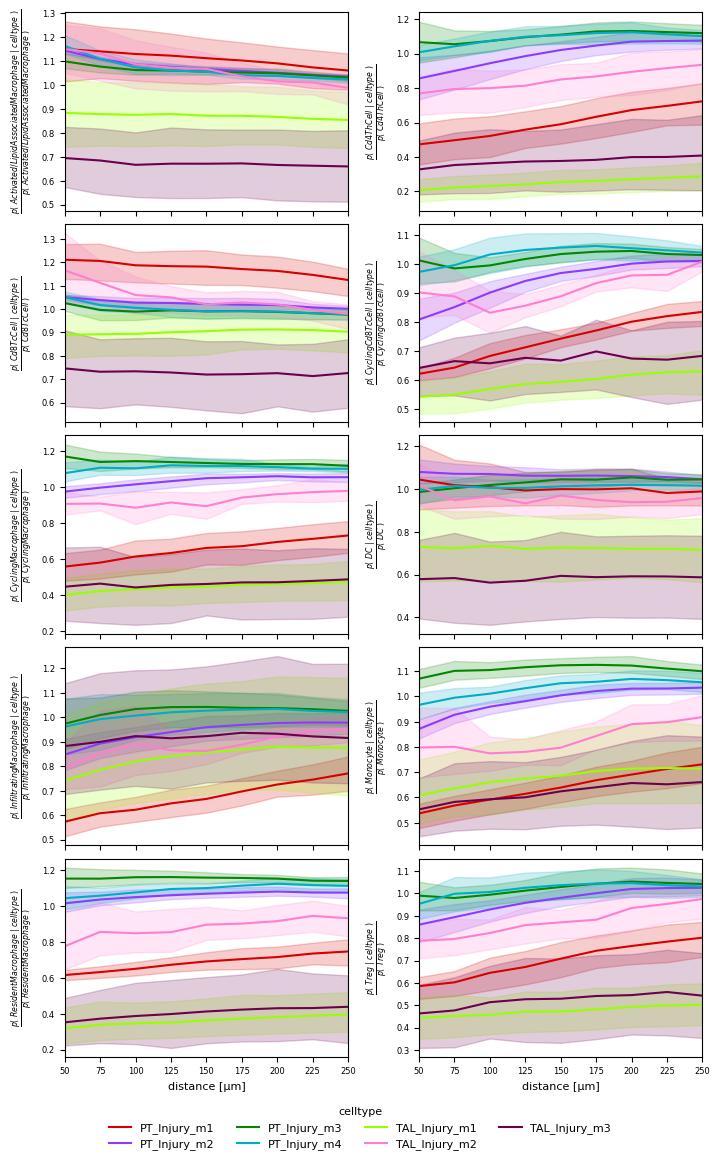

In [25]:
data = load_cooccurence(
    "co_occurence_long_celltype_sub.hdf5", ct_of_interest, immune_sub
)

n_rows = n_immune // 2

fig, axs = plt.subplots(
    n_rows, 2, sharex=True, figsize=(18 * CM, 2.3 * n_rows), layout="constrained"
)

for i, (ct, ax) in enumerate(zip(data.keys(), axs.ravel())):
    legend = "brief" if i == 0 else False
    sns.lineplot(
        data[ct],
        x="distance",
        y="ratio",
        hue="celltype",
        palette=cc.glasbey[:n_ct],
        legend=legend,
        ax=ax,
    )

    ax.set_ylabel(r"$\frac{p(\ " + ct + r"\ |\ celltype\ )}{p(\ " + ct + r"\ )}$")
    ax.set_xlabel("distance [µm]")
    ax.yaxis.get_label().set_visible(True)

fig.legend(
    *axs[0, 0].get_legend_handles_labels(),
    loc="outside lower center",
    title="celltype",
    frameon=False,
    ncols=4
)
axs[0, 0].get_legend().remove()

_ = axs[0, 0].set(xlim=(50, 250))

fig.savefig("enrichment_subtypes_long_dist.png", dpi=600)
fig.savefig("enrichment_subtypes_long_dist.svg")